## Boundary element method for acoustics (2D)

### Constant elements

This examples uses BEM_base to solve the Helmholtz and Laplace equations in bidimensional space using polynomial shape functions and NURBS curves to describe the boundary and interpolate domain variables (velocity potential and its flux for the Helmholtz equation and temperature and its flux for the Laplace equation). The first example which will be solved is acoustic duct problem, which has an analytical solution. If both ends of the acoustic duct are closed, then a Neumann boundary condition ($q = \bar{q}$) is applied. Let the boundary condition of the wall in one of the extremities not be null and that extremity will act as a piston. The analytical resonance frequencies for such ducts are given by
\begin{equation}
    F_{closed\ duct}\ (n,L) = \frac{\pi\ n\ c}{L}
\end{equation}
where $c$ is the wave propagation speed, $n=0,1,2,...$ is the mode number and $L$ is the length of the duct. The frequency is in rad/s, divide it to $2\ pi$ to obtain the frequency in Hz. The duct which will be studied has length = 100 mm and diameter = 10 mm. The speed of sound is $c = 343$ m/s and only the first non-zero mode will be studied ($n=1$).


In [1]:
c = 343*1000 # Speed of propagation in mm/s
F_closed(n,L,c) = pi*n*c/L # Analytical resonance frequency in rad/s
for n=1:3
    println("Mode n = $(n), L = $(L=100) m, F = $(F_closed(n,L,c)/(2*pi)) Hz.")
end

Mode n = 1, L = 100 m, F = 1715.0 Hz.
Mode n = 2, L = 100 m, F = 3430.0 Hz.
Mode n = 3, L = 100 m, F = 5145.0 Hz.


To solve this problem using constant bidimensional elements, the geometry must be described to BEM_base. Initially, the module for the constant bidimensional element will be loaded.

In [31]:
include("../src/const2D/const2D.jl")
using const2D

In [105]:
# First, include the module const2D
#include("../src/const2D/const2D.jl")
#using const2D
## Now, to define a new geometry, first one must declare the points,
# segments, boundary conditions, etc...
n = 5; # Mode number
L = 100; # Length of the duct in mm
d = 100; # Diameter of the duct in mm
c = 343*1000; # Speed of wave propagation in mm/s
k = F_closed(n,L,c)/c; # Resonance wave number
points = [1 0 0; 2 L 0; 3 L d; 4 0 d];
segments = [1 1 2 0; 2 2 3 0; 3 3 4 0; 4 4 1 0];
ne = 10; # Number of element per segment
MESH = [1 2*ne; 2 ne; 3 2*ne; 4 ne];
BCFace = [1 1 0; 2 1 0; 3 1 0; 4 0 1]; # Face 4 will act like a piston
fc = [0];
# Apply the discretization technique and builds the problems matrices
#for the geometrical points, physical nodes, elements' connectivity and
#boundary conditions
info = const2D.format_dad(points,segments,MESH,BCFace);
NOS_GEO,NOS,ELEM,CDC,normal = info;
# Now, the domain points will be created
#n_pdom = 100
#PONTOS_dom = zeros(n_pdom,3)
#for i = 1:n_pdom
#	PONTOS_dom[i,:] = [i ((100-0.1)/n_pdom)*i d/2]
#end
NPX = 30;
NPY = 11;
PONTOS_DOM=const2D.gera_p_in(NPX,NPY,points,segments); # generate domain points
n_pdom = size(PONTOS_DOM,1);
PONTOS_dom = zeros(n_pdom,3);
PONTOS_dom[:,2:3] = PONTOS_DOM[:,:];
for i = 1:n_pdom
    PONTOS_dom[i,1] = i;
end
u,q,udom,qdom = const2D.solve(info,PONTOS_dom,fc,BCFace,k);
#uH,qH,uintH,qintH = solveH(info,PONTOS_int,fc,BCFace,k);


Building A and b matrices using the traditional colocation BEM for constant elements.
  0.078817 seconds (554.67 k allocations: 11.061 MiB)
Evaluating at domain points.
  0.394507 seconds (2.95 M allocations: 58.683 MiB, 8.31% gc time)


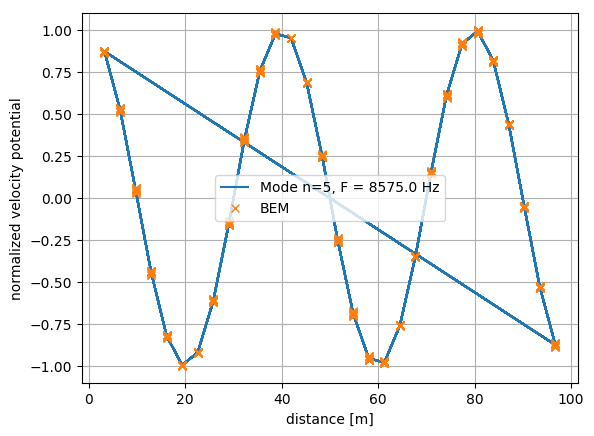

In [106]:
# Comparing the results
using PyPlot

phi_closed(x,n,L,c) = cos.(n*pi*(x./L))
figure()
plot(PONTOS_dom[:,2],phi_closed(PONTOS_dom[:,2],n,L,c),label="Mode n=$(n), F = $(F_closed(n,L,c)/(2*pi)) Hz")
hold(1)
plot(PONTOS_dom[:,2],real.(udom),label="BEM",marker="x",linestyle="none")
#plot(PONTOS_int[:,2],real.(uintH),label="H-BEM",marker="<")

legend()
xlabel("distance [m]")
ylabel("normalized velocity potential")
grid(1)
hold(0)

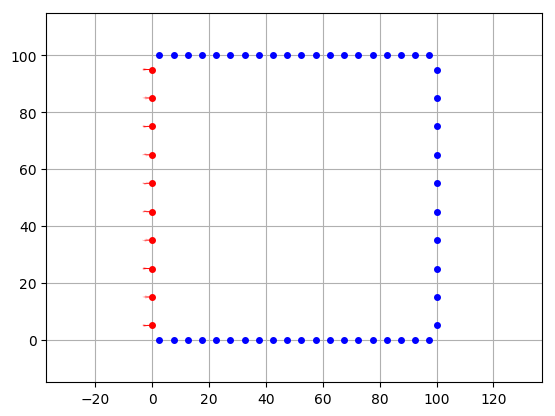

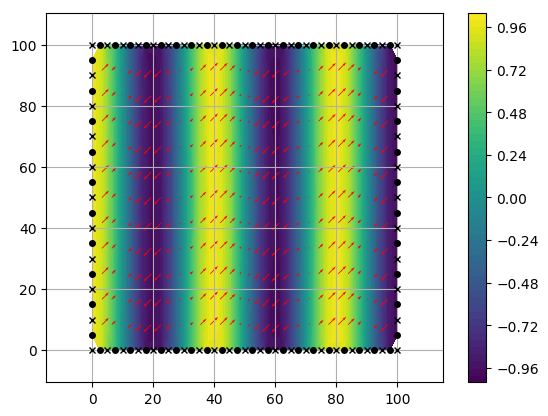

(390,)


(-15.0, 115.0)

In [110]:
tipoCDC = zeros(Bool,size(CDC,1));
tipoCDC[:] = CDC[:,2];
valorCDC = CDC[:,3]
const2D.mostra_problema(ELEM[:,2:3],NOS_GEO[:,2:3],NOS[:,2:3],tipoCDC,valorCDC,normal,real.(u),real.(q))
const2D.mostra_heatmap(NOS[:,2:3],PONTOS_dom[:,2:3],real.(u),real.(udom),NOS_GEO[:,2:3],ELEM[:,2:3],real.(udom),real.(qdom))

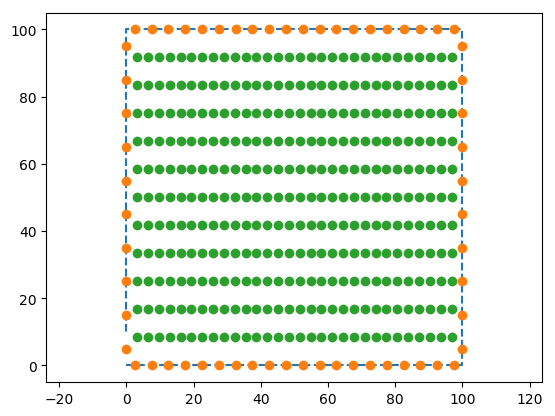

(-5.0, 105.0, -5.0, 105.0)

In [108]:
plot(NOS_GEO[:,2],NOS_GEO[:,3],linestyle="--")
hold(1)
plot(NOS[:,2],NOS[:,3],marker="o",linestyle="none")
plot(PONTOS_dom[:,2],PONTOS_dom[:,3],marker="o",linestyle="none")
axis("equal")